https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage?resource=download

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import category_encoders as ce



##### Reading in the data

In [152]:
df = pd.read_csv("bar_pass_prediction.csv")
df.columns

Index(['decile1b', 'decile3', 'ID', 'decile1', 'sex', 'race', 'cluster',
       'lsat', 'ugpa', 'zfygpa', 'DOB_yr', 'grad', 'zgpa', 'bar1', 'bar1_yr',
       'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'parttime',
       'male', 'race1', 'race2', 'Dropout', 'other', 'asian', 'black', 'hisp',
       'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040', 'indxgrp',
       'indxgrp2', 'dnn_bar_pass_prediction', 'gpa'],
      dtype='object')

##### Dropping unnessecary columns

In [153]:
df.drop(['cluster', 'bar1', 'bar1_yr', 'bar2', 
         'bar2_yr', 'bar_passed', 'race', 'race2', 'asian', 'black', 'hisp',
         'Dropout', 'parttime', 'DOB_yr', 'index6040', 'indxgrp', 'indxgrp2', 
         'dnn_bar_pass_prediction'], axis=1, inplace=True)


In [154]:
df.head()

,decile1b,decile3,ID,decile1,sex,lsat,ugpa,zfygpa,grad,zgpa,...,fam_inc,age,gender,male,race1,other,pass_bar,bar,tier,gpa
0,10.0,10.0,2,10.0,1.0,44.0,3.5,1.33,Y,1.88,...,5.0,-62.0,female,0.0,white,0,1,a Passed 1st time,4.0,3.5
1,5.0,4.0,3,5.0,1.0,29.0,3.5,-0.11,Y,-0.57,...,4.0,-62.0,female,0.0,white,0,1,a Passed 1st time,2.0,3.5
2,3.0,2.0,36,3.0,2.0,36.0,3.5,-0.64,Y,-1.12,...,1.0,-58.0,male,1.0,white,0,1,a Passed 1st time,3.0,3.5
3,7.0,4.0,52,7.0,2.0,39.0,3.5,0.34,Y,-0.49,...,4.0,-51.0,male,1.0,white,0,1,a Passed 1st time,3.0,3.5
4,9.0,8.0,55,9.0,2.0,48.0,3.5,1.02,Y,0.76,...,4.0,-61.0,male,1.0,white,0,1,a Passed 1st time,5.0,3.5


##### Replacing text values with numerical values

In [155]:

df['gender'].replace('male', 1, inplace = True)
df['gender'].replace('female', 0, inplace = True)


df['grad'].replace('Y', 1, inplace = True)
df['grad'].replace('N', 0, inplace = True)

/var/folders/c8/m1hqt__d0d3fr_c_x36gt6d00000gn/T/ipykernel_36732/915172391.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['gender'].replace('male', 1, inplace = True)
/var/folders/c8/m1hqt__d0d3fr_c_x36gt6d00000gn/T/ipykernel_36732/915172391.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

In [156]:
# TODO Should i dropna?
df['race1'].dropna

<bound method Series.dropna of 0        white
1        white
2        white
3        white
4        white
         ...  
22402    black
22403    black
22404    black
22405    white
22406    white
Name: race1, Length: 22407, dtype: object>

In [157]:
df.columns

Index(['decile1b', 'decile3', 'ID', 'decile1', 'sex', 'lsat', 'ugpa', 'zfygpa',
       'grad', 'zgpa', 'fulltime', 'fam_inc', 'age', 'gender', 'male', 'race1',
       'other', 'pass_bar', 'bar', 'tier', 'gpa'],
      dtype='object')

In [158]:
df['bar']

0        a Passed 1st time
1        a Passed 1st time
2        a Passed 1st time
3        a Passed 1st time
4        a Passed 1st time
               ...        
22402             c Failed
22403             c Failed
22404    a Passed 1st time
22405    a Passed 1st time
22406    a Passed 1st time
Name: bar, Length: 22407, dtype: object

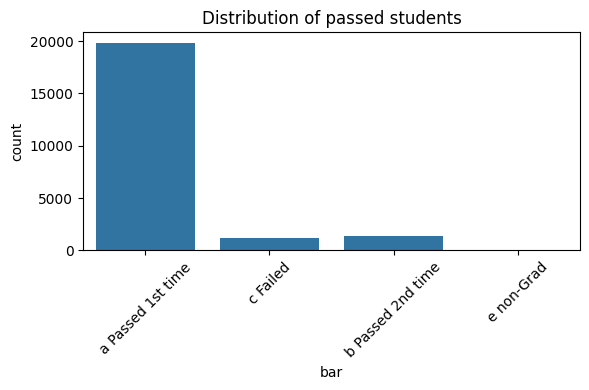

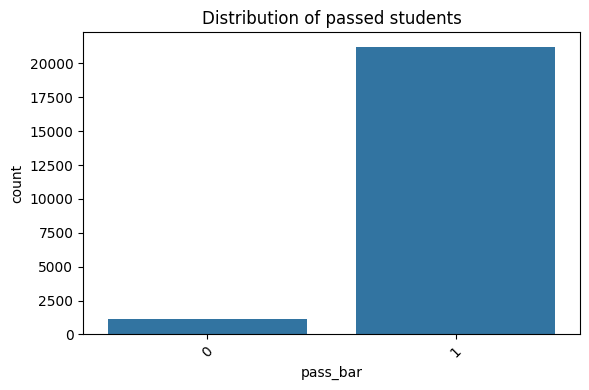

In [159]:
# Plotting the overall distribution of the target column
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x=df['bar'])
plt.title(f'Distribution of passed students')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 4))
sns.countplot(data=df, x=df['pass_bar'])
plt.title(f'Distribution of passed students')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Counting the distribution of different genders and races

In [160]:
df['gender'].value_counts()


gender
1.0    12576
0.0     9826
Name: count, dtype: int64

In [161]:
df['race1'].value_counts()


race1
white    18716
black     1343
hisp      1027
asian      897
other      408
Name: count, dtype: int64

We see that there are more men by about 12 percent and the amount of white students are generally about 80 percent more in comparison to each other individual race

Now let's visualise the pass rate in relation to sex and race:

/var/folders/c8/m1hqt__d0d3fr_c_x36gt6d00000gn/T/ipykernel_36732/3675689406.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object:


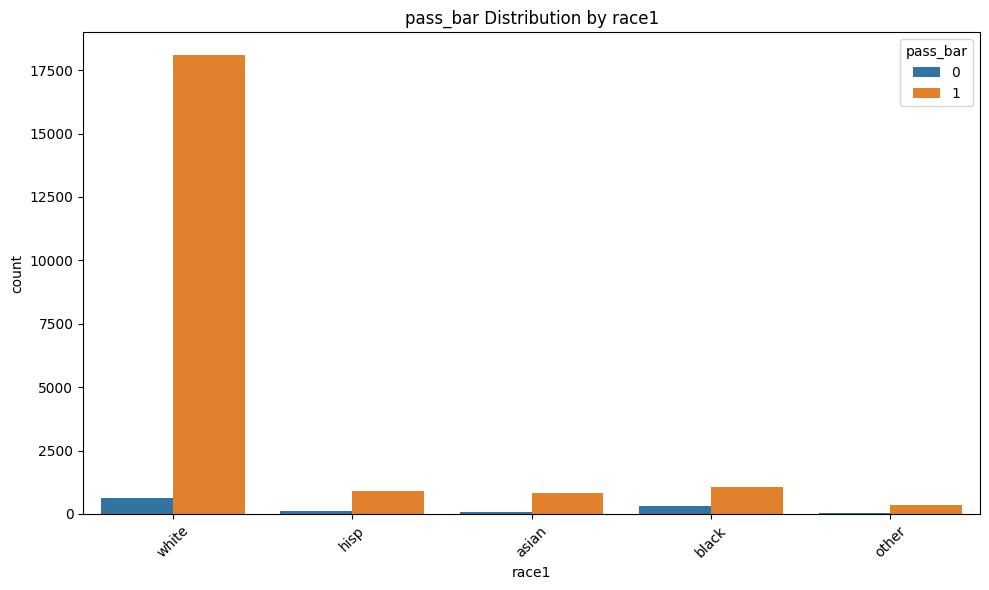

/var/folders/c8/m1hqt__d0d3fr_c_x36gt6d00000gn/T/ipykernel_36732/3675689406.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object:


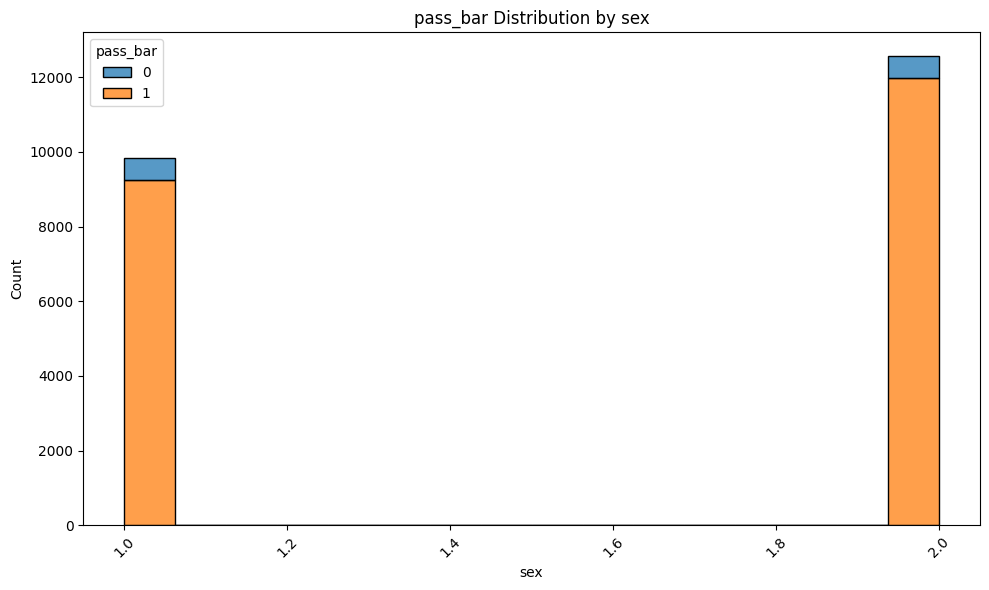

In [162]:


def visualize_columns(df, columns, target):

    # Iterate through each column in the list
    for col in columns:
        plt.figure(figsize=(10, 6))
        
        # Plotting the relationship between target and each column
        if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object:
            sns.countplot(data=df, x=col, hue=target)
        else:
            sns.histplot(data=df, x=col, hue=target, multiple="stack", kde=False)
        
        plt.title(f'{target} Distribution by {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Example usage
# Assuming df is your DataFrame and you want to visualize specific columns
columns_to_visualize = ['race1', 'sex']
visualize_columns(df, columns_to_visualize, 'pass_bar')


### One hot encoding

In [163]:
# onehot_encoder = ce.one_hot.OneHotEncoder()
# onehot_encoder.fit(df['race1'])
# df_ohe = onehot_encoder.transform(df['race1'])

# # Merging the one hot encoded values for race with the original dataframe
# df = df.drop(['race1'], axis=1)
# df = pd.concat([df, df_ohe], axis=1)

There are many different columns related to GPA. Here i will make a correlation plot to see if they represent the same values

<Axes: >

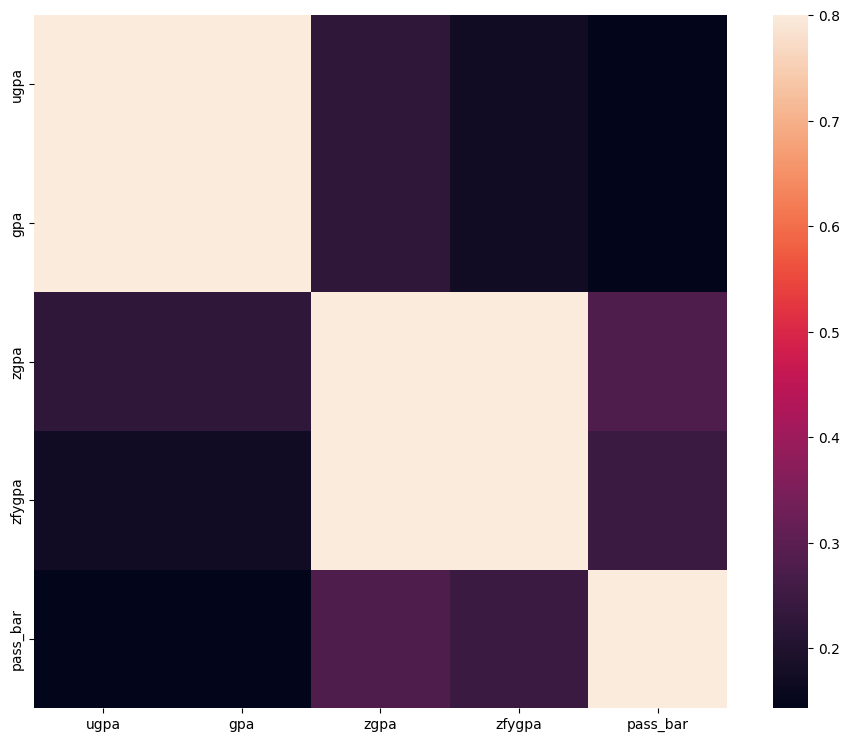

In [164]:
df_gpa = df[['ugpa', 'gpa', 'zgpa', 'zfygpa','pass_bar']]


corrmat = df_gpa.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

It seems that zfygpa and zgpa are not correlated to gpa and ugpa, but they are very correlated to each other. Likewise, gpa and ugpa are also very correlated.


I will keep UGPA since it is the gpa from the students undergraduate GPA.



In [165]:
df_gpa = df_gpa.drop(['gpa', 'zfygpa', 'zgpa'], axis = 1)


### Checking for missing values

In [166]:
df.isnull().sum()

decile1b    1604
decile3     1604
ID             0
decile1     1092
sex            5
lsat           0
ugpa           0
zfygpa       984
grad           3
zgpa        1289
fulltime      34
fam_inc      289
age           89
gender         5
male           5
race1         16
other          0
pass_bar       0
bar            0
tier          96
gpa            0
dtype: int64

Since there are quite a lot of missing values I will fill them for now. For numerica columns, I will fill with the mean, and for categorical columns, I will fill with the mode.

In [169]:
import pandas as pd
import numpy as np


# Identify columns with missing values and count them
missing_counts = df.isnull().sum()
print("Missing Value Counts:")
print(missing_counts)

# Fill missing values based on data type and context
# Example strategies - replace NaN with mean for numeric columns, and mode for categorical columns

# Numeric columns
numeric_cols = ['decile1b', 'decile3', 'decile1', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'fam_inc', 'age', 'tier', 'gpa']
for col in numeric_cols:
    df[col].fillna(df[col].mean(), inplace=True)

# Categorical columns
categorical_cols = ['ID', 'sex', 'grad', 'fulltime', 'gender', 'male', 'other', 'pass_bar', 'bar', 'race1']
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Verify that all missing values are filled
missing_counts_after = df.isnull().sum()
print("\nMissing Value Counts after filling:")
print(missing_counts_after)



Missing Value Counts:
decile1b     0
decile3      0
ID           0
decile1      0
sex          0
lsat         0
ugpa         0
zfygpa       0
grad         0
zgpa         0
fulltime     0
fam_inc      0
age          0
gender       0
male         0
race1       16
other        0
pass_bar     0
bar          0
tier         0
gpa          0
dtype: int64

Missing Value Counts after filling:
decile1b    0
decile3     0
ID          0
decile1     0
sex         0
lsat        0
ugpa        0
zfygpa      0
grad        0
zgpa        0
fulltime    0
fam_inc     0
age         0
gender      0
male        0
race1       0
other       0
pass_bar    0
bar         0
tier        0
gpa         0
dtype: int64


/var/folders/c8/m1hqt__d0d3fr_c_x36gt6d00000gn/T/ipykernel_36732/2063380699.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/var/folders/c8/m1hqt__d0d3fr_c_x36gt6d00000gn/T/ipykernel_36732/2063380699.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [170]:
df.to_csv("processed_data.csv")

In [ ]:

corrmat = df.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.3, square=True)

ValueError: could not convert string to float: 'X'